# Expected Calibration Error computation

In [1]:
!pip install pycocotools tqdm tidecv ultralytics -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 921.5/921.5 kB 16.8 MB/s eta 0:00:0000:01


In [41]:
import os
print(os.listdir("/kaggle/input/yolov8x/pytorch/default/1/"))

['yolov8x.pt']


In [3]:
import numpy as np
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

from tidecv import TIDE, datasets

from dataclasses import dataclass
from typing import List, Tuple, Dict, Set
from tqdm import tqdm
from collections import defaultdict

In [ ]:
np.random.seed(2022482)

### (a) part: downloading the COCO 2017 validation set using the Ultralytics API

In [5]:
from ultralytics.utils.downloads import download
from pathlib import Path

dir = Path("Coco 2017 Data")  # dataset root dir
# Download labels
url = 'https://github.com/ultralytics/assets/releases/download/v0.0.0/'
urls = [url + ('coco2017labels.zip')]  # labels
download(urls, dir=dir.parent)
# Download data
urls = ['http://images.cocodataset.org/zips/val2017.zip']  # 1G, 5k images
download(urls, dir=dir / 'images', threads=3)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 46.4M/46.4M [00:00<00:00, 205MB/s]
Unzipping coco2017labels.zip to /kaggle/working/coco...: 100%|██████████| 122232/122232 [00:14<00:00, 8688.85file/s]

### (b) part: Running YOLOv8 and Saving Predictions

In [6]:
from ultralytics import YOLO
import json
from pathlib import Path

ground_truth = json.load(open('/kaggle/working/coco/annotations/instances_val2017.json'))
category_mapping = {i: x['id'] for i, x in enumerate(ground_truth['categories'])}
print(category_mapping)

model = YOLO("/kaggle/input/yolov8x/pytorch/default/1/yolov8x.pt")

images = Path("Coco 2017 Data/images/val2017")
results = []

for img_path in tqdm(images.iterdir()):
    predictions = model(img_path, verbose=False)
    for box in predictions[0].boxes:
        # print(box)
        # print(box.data)
        x, y, x2, y2 = box.data[0, :4]
        x, y, x2, y2 = x.item(), y.item(), x2.item(), y2.item()
        w, h = x2 - x, y2 - y

        results.append({
            'image_id': int(img_path.stem),
            'category_id': category_mapping[int(box.data[0][5])],
            'bbox': [round(x, 1), round(y, 1), round(w, 1), round(h, 1)],
            'score': float(box.data[0][4].item())
        })


{0: 1, 1: 2, 2: 3, 3: 4, 4: 5, 5: 6, 6: 7, 7: 8, 8: 9, 9: 10, 10: 11, 11: 13, 12: 14, 13: 15, 14: 16, 15: 17, 16: 18, 17: 19, 18: 20, 19: 21, 20: 22, 21: 23, 22: 24, 23: 25, 24: 27, 25: 28, 26: 31, 27: 32, 28: 33, 29: 34, 30: 35, 31: 36, 32: 37, 33: 38, 34: 39, 35: 40, 36: 41, 37: 42, 38: 43, 39: 44, 40: 46, 41: 47, 42: 48, 43: 49, 44: 50, 45: 51, 46: 52, 47: 53, 48: 54, 49: 55, 50: 56, 51: 57, 52: 58, 53: 59, 54: 60, 55: 61, 56: 62, 57: 63, 58: 64, 59: 65, 60: 67, 61: 70, 62: 72, 63: 73, 64: 74, 65: 75, 66: 76, 67: 77, 68: 78, 69: 79, 70: 80, 71: 81, 72: 82, 73: 84, 74: 85, 75: 86, 76: 87, 77: 88, 78: 89, 79: 90}


5000it [04:51, 17.18it/s]


In [7]:
print(len(results))

with open('coco_predictions.json', 'w') as f:
    json.dump(results, f)

34600


In [8]:
true_predictions = COCO("/kaggle/working/coco/annotations/instances_val2017.json")
pred_predictions = true_predictions.loadRes("coco_predictions.json")

coco_eval = COCOeval(true_predictions, pred_predictions, 'bbox')
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()

print(coco_eval.stats)


loading annotations into memory...
Done (t=0.66s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.38s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=12.39s).
Accumulating evaluation results...
DONE (t=2.46s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.480
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.616
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.524
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.285
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.534
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.667
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.363
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.539
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDet

In [9]:
mAP = coco_eval.stats[0]  # mAP @ IoU=0.50:0.95 | area=all | maxDets=100
print(f"mAP: {mAP:.4f}")

mAP: 0.4805


### (c) part: TIDE Error Analysis

-- coco_predictions --

bbox AP @ 50: 61.61

                         Main Errors
  Type      Cls      Loc     Both     Dupe      Bkg     Miss  
-------------------------------------------------------------
   dAP     2.37     4.87     0.57     0.13     1.59    21.65  

        Special Error
  Type   FalsePos   FalseNeg  
-----------------------------
   dAP       5.18      29.27  



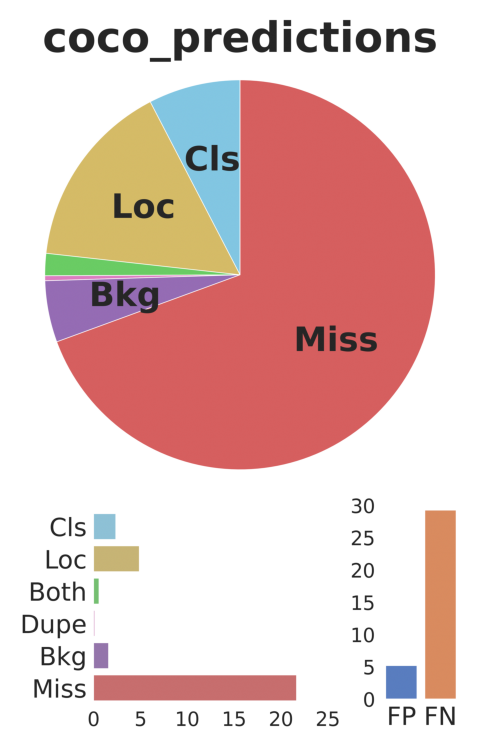

In [21]:
ground_truth_json = "/kaggle/working/coco/annotations/instances_val2017.json"
predictions_json = "/kaggle/working/coco_predictions.json"

tide = TIDE()
tide.evaluate(datasets.COCO(ground_truth_json), datasets.COCOResult(predictions_json), mode=TIDE.BOX)

tide.summarize()
tide.plot()

### (d) part: Computing ECE

In [32]:
def calculate_ece(ground_truth, predictions, M):
    # storing ground truth predictions
    image_categories_true = defaultdict(lambda: defaultdict(int))
    for true_box in ground_truth['annotations']:
        image_categories_true[true_box['image_id']][true_box['category_id']] += 1

    # storing my predictions
    image_categories_pred = defaultdict(list)
    for pred_box in predictions:
        image_categories_pred[(pred_box['image_id'], pred_box['category_id'])].append(pred_box)

    confidences = []
    accuracies = []

    # marking the correct predictions as accurate
    for (image_id, cat), preds_list in image_categories_pred.items():
        preds_sorted = sorted(preds_list, key=lambda p: p['score'], reverse=True)
        gt_count = image_categories_true.get(image_id, {}).get(cat, 0)
        for i, pred in enumerate(preds_sorted):
            correct = 1 if i < gt_count else 0
            confidences.append(pred['score'])
            accuracies.append(correct)

    confidences = np.array(confidences)
    accuracies = np.array(accuracies)

    # binning into M intervals
    bin_boundaries = np.linspace(0, 1, M + 1)
    bin_indices = np.digitize(confidences, bin_boundaries) - 1

    ece = 0.0
    total_samples = len(confidences)

    for i in range(M):
        bin_mask = bin_indices == i
        bin_size = np.sum(bin_mask)
        if bin_size > 0:
            acc_b_m = np.mean(accuracies[bin_mask])
            conf_b_m = np.mean(confidences[bin_mask])
            ece += (bin_size / total_samples) * abs(acc_b_m - conf_b_m)
    
    return ece

ground_truth_json = "/kaggle/working/coco/annotations/instances_val2017.json"
predictions_json = "/kaggle/working/coco_predictions.json"

ground_truth = json.load(open(ground_truth_json))
predictions = json.load(open(predictions_json))
M = 10

ece = calculate_ece(ground_truth, predictions, M)
print(f"Expected Calibration Error (ECE): {ece:.4f}")

Expected Calibration Error (ECE): 0.1598


### (e) part: TIDE Analysis & ECE for each object scale

-- coco_predictions_small --

bbox AP @ 50: 32.10

                         Main Errors
  Type      Cls      Loc     Both     Dupe      Bkg     Miss  
-------------------------------------------------------------
   dAP     2.40     2.14     0.19     0.05     5.28    36.31  

        Special Error
  Type   FalsePos   FalseNeg  
-----------------------------
   dAP       7.13      43.91  



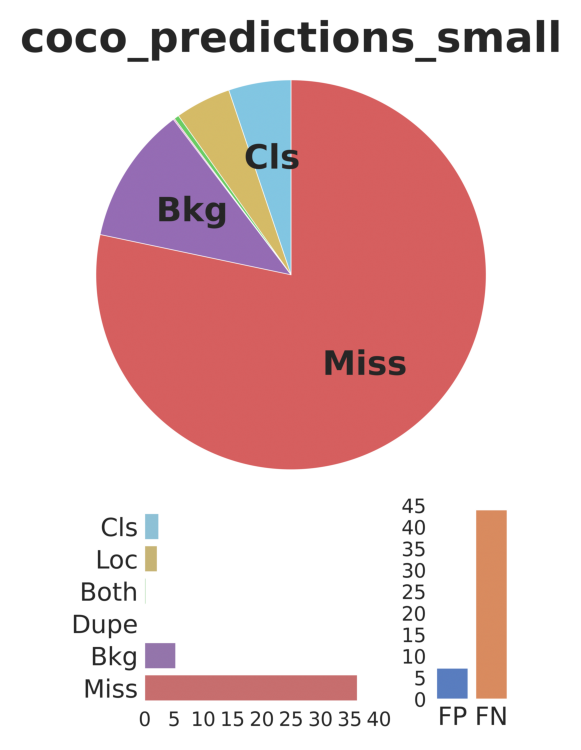

ECE for small objects: 0.2383
-- coco_predictions_medium --

bbox AP @ 50: 58.26

                         Main Errors
  Type      Cls      Loc     Both     Dupe      Bkg     Miss  
-------------------------------------------------------------
   dAP     1.97     2.80     0.50     0.04     5.39    22.63  

        Special Error
  Type   FalsePos   FalseNeg  
-----------------------------
   dAP       8.07      27.80  



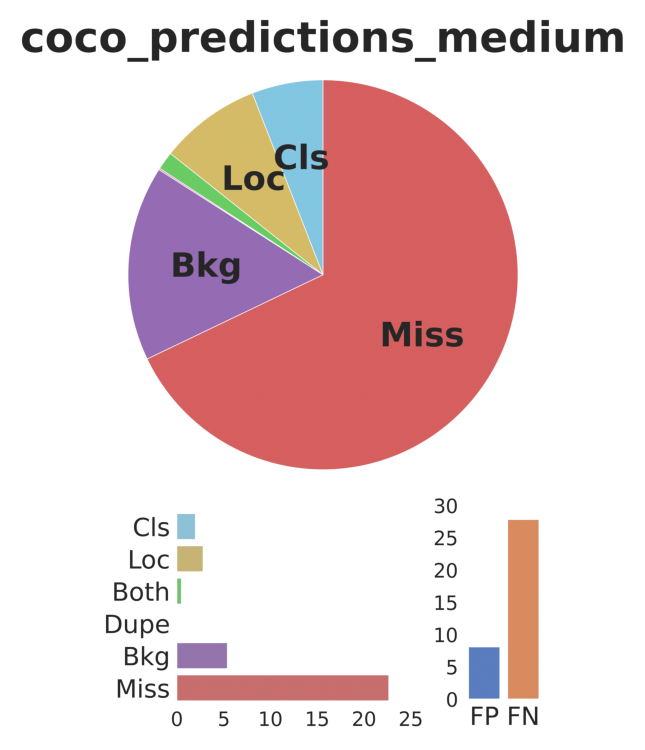

ECE for medium objects: 0.1006
-- coco_predictions_large --

bbox AP @ 50: 75.18

                         Main Errors
  Type      Cls      Loc     Both     Dupe      Bkg     Miss  
-------------------------------------------------------------
   dAP     2.84     3.55     0.78     0.11     1.45    12.55  

        Special Error
  Type   FalsePos   FalseNeg  
-----------------------------
   dAP       4.65      18.46  



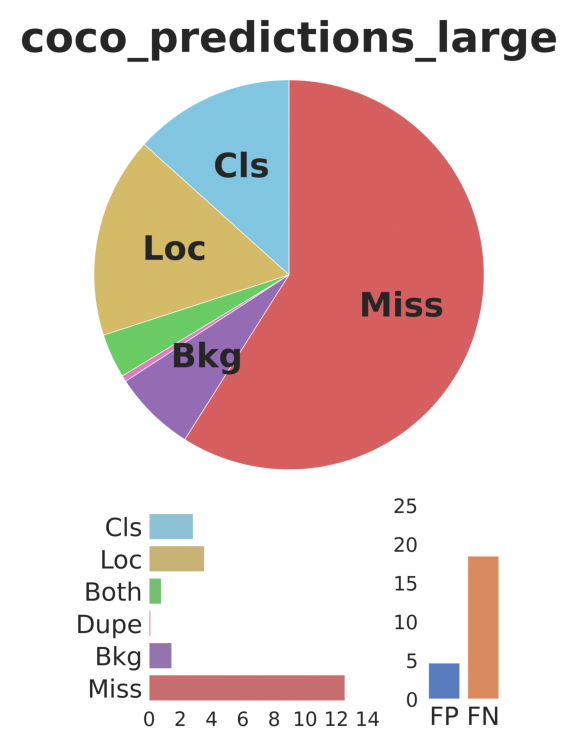

ECE for large objects: 0.0447


In [40]:
ground_truth_json = "/kaggle/working/coco/annotations/instances_val2017.json"
predictions_json = "/kaggle/working/coco_predictions.json"

ground_truth_full = json.load(open(ground_truth_json))
predictions_full = json.load(open(predictions_json))

# filtering the ground truth and predictions based on the object scale
ground_truth_small = []
ground_truth_medium = []
ground_truth_large = []

for ann in ground_truth_full["annotations"]:
    x, y, w, h = ann["bbox"]
    area = w * h
    if area < 36*36:
        ground_truth_small.append(ann)
    elif area < 96*96:
        ground_truth_medium.append(ann)
    else:
        ground_truth_large.append(ann)

for scale in ["small", "medium", "large"]:
    ground_truth_full_copy = ground_truth_full.copy()
    ground_truth_full_copy.pop("annotations")
    ground_truth_full_copy["annotations"] = locals()[f"ground_truth_{scale}"]
    with open(f"coco_ground_truth_{scale}.json", "w") as f:
        json.dump(ground_truth_full_copy, f)

pred_small = []
pred_medium = []
pred_large = []

for pred in predictions_full:
    x, y, w, h = pred["bbox"]
    area = w * h
    if area < 36*36:
        pred_small.append(pred)
    elif area < 96*96:
        pred_medium.append(pred)
    else:
        pred_large.append(pred)

with open("coco_predictions_small.json", "w") as f:
    json.dump(pred_small, f)
with open("coco_predictions_medium.json", "w") as f:
    json.dump(pred_medium, f)
with open("coco_predictions_large.json", "w") as f:
    json.dump(pred_large, f)

for scale in ["small", "medium", "large"]:
    tide = TIDE()
    tide.evaluate(datasets.COCO(f"coco_ground_truth_{scale}.json"), datasets.COCOResult(f"coco_predictions_{scale}.json"), mode=TIDE.BOX)
    tide.summarize()
    tide.plot()

    ground_truth_filtered = json.load(open(f"coco_ground_truth_{scale}.json"))
    preds_filtered = json.load(open(f"coco_predictions_{scale}.json"))

    ece = calculate_ece(ground_truth_filtered, preds_filtered, M)
    print(f"ECE for {scale} objects: {ece:.4f}")

### (f) part: In report

### --------------------I haven't used any cell beyond this point------------------

# Problem 1: Expected Calibration Error (ECE) 

ECE is a metric to evaluate the calibration of a model. It is defined as the expected value of the absolute difference between the accuracy and the confidence of the model. The confidence of the model is the probability assigned to the predicted class. The accuracy is 1 if the prediction is correct and 0 otherwise. The ECE is computed by dividing the confidence interval [0, 1] into M equally spaced bins and computing the weighted average of the absolute difference between the accuracy and the confidence in each bin. The weights are the proportion of samples in each bin. The ECE is defined as:

\begin{equation}
ECE = \sum_{m=1}^{M} \frac{B_m}{N} \left| \text{acc}(B_m) - \text{conf}(B_m) \right|
\end{equation}

where $B_m$ is the set of samples in bin $m$, $N$ is the total number of samples, $\text{acc}(B_m)$ is the accuracy of the model in bin $m$, and $\text{conf}(B_m)$ is the confidence of the model in bin $m$. The accuracy and confidence in bin $m$ are defined as:

\begin{equation}
\text{acc}(B_m) = \frac{1}{|B_m|} \sum_{i \in B_m} \mathbb{1} \left( y_i = \hat{y}_i \right)
\end{equation}

\begin{equation}
\text{conf}(B_m) = \frac{1}{|B_m|} \sum_{i \in B_m} p_i
\end{equation}

where $y_i$ is the true label of sample $i$, $\hat{y}_i$ is the predicted label of sample $i$, $p_i$ is the confidence of the model for sample $i$, and $\mathbb{1}(\cdot)$ is the indicator function.


## Starter Code

The following section contains some starter code to help you prepare the data using the COCO API. You can use this code to preprocess the data, or you can write your own code.

In [15]:
@dataclass
class Detection:
    bbox: np.ndarray  # [x1, y1, x2, y2]
    class_id: int
    confidence: float

@dataclass
class GroundTruth:
    bbox: np.ndarray  # [x1, y1, x2, y2]
    class_id: int

In [16]:
def coco_to_corners(bbox):
    """Convert COCO bbox [x,y,w,h] to corners format [x1,y1,x2,y2]"""
    return np.array([
        bbox[0],
        bbox[1],
        bbox[0] + bbox[2],
        bbox[1] + bbox[3]
    ])

def get_image_annotations(coco_gt, coco_dt, img_id, max_dets=100):
    """Get list of ground truth and detection annotations across all images"""
    gt_ids = coco_gt.getAnnIds(imgIds=img_id)
    gt_anns = coco_gt.loadAnns(gt_ids)
    gts = [
        GroundTruth(
            bbox=coco_to_corners(ann['bbox']),
            class_id=ann['category_id']
        )
        for ann in gt_anns
    ]

    # Get detections
    dt_ids = coco_dt.getAnnIds(imgIds=img_id)
    dt_anns = coco_dt.loadAnns(dt_ids)
    if max_dets is not None:
        dt_anns = sorted(dt_anns, key=lambda x: x['score'], reverse=True)[:max_dets]
    dets = [
        Detection(
            bbox=coco_to_corners(ann['bbox']),
            class_id=ann['category_id'],
            confidence=ann['score']
        )
        for ann in dt_anns
    ]

    return gts, dets

def prepare_inputs(coco_gt, coco_dt, max_dets=100):
    """Convert COCO format to TIDE format for all images"""
    all_gts = []
    all_dets = []
    
    for img_id in tqdm(coco_gt.getImgIds(), desc="Processing images"):
        gts, dets = get_image_annotations(coco_gt, coco_dt, img_id, max_dets)
        all_gts.extend(gts)
        all_dets.extend(dets)
    
    return all_gts, all_dets

In [18]:
predictions_json = ""   # Path to the predictions JSON file
ground_truth_json = ""  # Path to the val annotations JSON file

coco_gt = COCO(ground_truth_json)       # Load ground truth annotations
coco_dt = coco_gt.loadRes(predictions_json) # Load predictions

loading annotations into memory...
Done (t=0.71s)
creating index...
index created!
Loading and preparing results...
DONE (t=2.78s)
creating index...
index created!


In [23]:
gts, dets = prepare_inputs(coco_gt, coco_dt, max_dets=100)
len(gts), len(dets)

Processing images: 100%|██████████| 5000/5000 [00:01<00:00, 3699.39it/s]


(36781, 279003, 70734)

## Your task: implement code to compute the Expected Calibration Error.

## Solution

# Problem 2: Compute TIDE statistics.

## Solution

# Problem 3: size-based analysis.

## Starter Code: Spatial Grid data structure.


## Spatial Grid Implementation

The `SpatialGrid` class implements a spatial indexing data structure that helps efficiently find nearby objects. Using this data structure is useful for our size-based analysis as it significantly reduces the time complexity of finding overlapping boxes.

### How it works:
1. The image space is divided into a grid of cells. The size of the cells is defined by the `cell_size` parameter.
2. Each bounding box is mapped to the cells it overlaps.
3. When searching for nearby objects, we only need to check objects in the relevant grid cells.

### Usage Example:
```python
grid = SpatialGrid(cell_size=100)
grid.add_box(0, [100, 100, 200, 200])  # Add a box with index 0, and bbox coordinates [100, 100, 200, 200]
nearby = grid.get_nearby_indices([150, 150, 250, 250])  # Find boxes near the bbox [150, 150, 250, 250]
```

In [26]:
class SpatialGrid:
    def __init__(self, cell_size: int = 100):
        """A spatial indexing structure for efficient nearby object queries.
        
        This data structure divides 2D space into a grid and maintains a mapping of
        which objects overlap with each grid cell, enabling efficient spatial queries.
        """
        self.cell_size: int = cell_size
        # self.grid = defaultdict(list)
        self.grid: Dict[Tuple[int, int], List[int]] = defaultdict(list)
    
    def get_cell_coords(self, bbox: np.ndarray) -> Set[Tuple[int, int]]:
        """Get all grid cells that a bounding box overlaps with.
        
        Args:
            bbox: Bounding box coordinates [x1, y1, x2, y2]
                where (x1, y1) is the top-left corner and (x2, y2) is the bottom-right corner

        Returns:
            Set of (x, y) grid cell coordinates
        """
        x1, y1, x2, y2 = bbox
        start_x = int(x1 // self.cell_size)
        end_x = int(x2 // self.cell_size)
        start_y = int(y1 // self.cell_size)
        end_y = int(y2 // self.cell_size)
        return {(i, j) for i in range(start_x, end_x + 1) 
                       for j in range(start_y, end_y + 1)}
    
    def add_box(self, idx: int, bbox: np.ndarray):
        """Add a bounding box to the spatial grid.
        
        Args:
            idx: Index of the bounding box
            bbox: Bounding box coordinates [x1, y1, x2, y2]
        """
        cells = self.get_cell_coords(bbox)
        for cell in cells:
            self.grid[cell].append(idx)
    
    def get_nearby_indices(self, bbox: np.ndarray) -> Set[int]:
        """Get indices of bounding boxes that are near the given bounding box.
        
        Args:
            bbox: Bounding box coordinates [x1, y1, x2, y2]
            
        Returns:
            Set of indices of nearby bounding boxes
        """
        cells = self.get_cell_coords(bbox)
        nearby = set()
        for cell in cells:
            nearby.update(self.grid[cell])
        return nearby

In [27]:
# Size thresholds as per COCO
SMALL_THRESH = 32 * 32
MEDIUM_THRESH = 96 * 96

## Your task: Implement the size-based ECE computation.

## Solution:

# Size-based TIDE computation:

## Solution: